Configurazione suggerita: 9S12P  (totale: 108 celle)
✅ Le celle entrano nella forma disponibile.
✅ Layout salvato in layout.json


/var/folders/20/448h2f1933x4jpn5p3l2lb7c0000gn/T/ipykernel_17684/4138412261.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(gruppi))


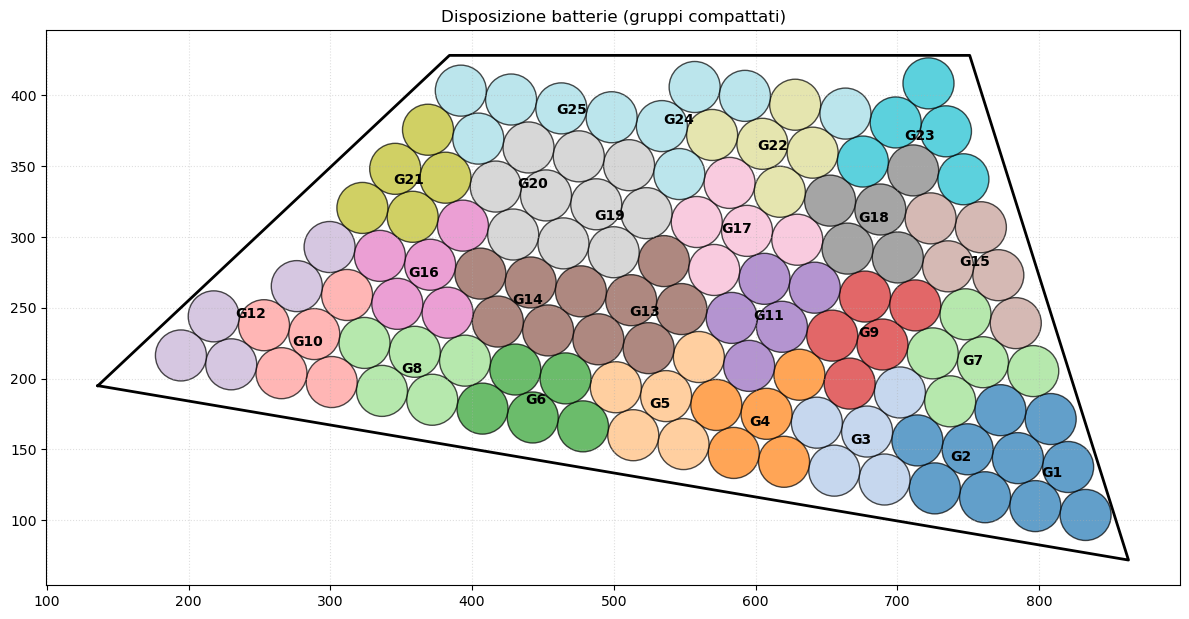

In [28]:
import json
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from pathlib import Path

##############################################################
# 1. CONFIGURATION & UTILITIES                               #
##############################################################

DIST_FACTOR = 3.0  # multiplier of radius used to judge adjacency


def calcola_configurazione_batteria(v_cella: float, ah_cella: float,
                                   v_target: float, ah_target: float,
                                   celle_disponibili: int):
    """Calcola la configurazione serie/parallelo più vicina al target.

    Restituisce (S, P, totale_celle)
    """
    s = round(v_target / v_cella)
    p = round(ah_target / ah_cella)
    totale = s * p

    print(f"Configurazione suggerita: {s}S{p}P  (totale: {totale} celle)")
    if totale <= celle_disponibili:
        print("✅ Le celle entrano nella forma disponibile.")
    else:
        print("⚠️ Troppe celle. Considera di abbassare la capacità o cambiare disposizione.")
    return s, p, totale


##############################################################
# 2. PRE‑PROCESSING                                          #
##############################################################

def build_adjacency(centers: list[tuple[float, float]], radius: float) -> nx.Graph:
    """Costruisce un grafo di adiacenza basato sulla distanza euclidea."""
    G = nx.Graph()
    for i, c1 in enumerate(centers):
        for j in range(i + 1, len(centers)):
            if np.linalg.norm(np.subtract(c1, centers[j])) <= DIST_FACTOR * radius:
                G.add_edge(i, j)
    return G


def elimina_celle_in_eccesso(centers: list[tuple[float, float]], required: int, radius: float):
    """Mantiene la componente più grande e rimuove celle finché ne restano 'required'."""

    if len(centers) <= required:
        return centers

    G = build_adjacency(centers, radius)
    largest = max(nx.connected_components(G), key=len)
    kept = list(largest)

    # se servono comunque meno celle, rimuovi quelle col minor grado (meno collegate)
    while len(kept) > required:
        degs = [(n, G.degree[n]) for n in kept]
        worst = min(degs, key=lambda x: x[1])[0]
        kept.remove(worst)

    return [centers[i] for i in kept]


##############################################################
# 3. CREAZIONE GRUPPI (CONTIGUI & QUASI‑RETTANGOLARI)        #
##############################################################

def _bounding_box_area(points: list[tuple[float, float]]):
    xs, ys = zip(*points)
    return (max(xs) - min(xs)) * (max(ys) - min(ys))


def crea_gruppi_regolari(centers: list[tuple[float, float]], S: int, P: int, radius: float):
    """Former gruppi contigui usando BFS sull'adiacenza.

    Il criterio di scelta dei vicini mira a minimizzare l'area del
    bounding‑box del gruppo (più rettangolare = area ridotta).
    """
    G = build_adjacency(centers, radius)
    used: set[int] = set()
    idx_sorted = sorted(range(len(centers)), key=lambda i: (centers[i][1], centers[i][0]))
    gruppi: list[list[tuple[float, float]]] = []

    for seed in idx_sorted:
        if seed in used:
            continue
        group_idx = [seed]
        frontier = [seed]
        used.add(seed)

        # BFS fino a raggiungere P celle
        while frontier and len(group_idx) < P:
            current = frontier.pop(0)
            neighbors = [n for n in G.neighbors(current) if n not in used]
            # Ordina i vicini per distanza dal seed → compattare
            neighbors.sort(key=lambda n: np.linalg.norm(np.subtract(centers[n], centers[seed])))
            for n in neighbors:
                group_idx.append(n)
                used.add(n)
                frontier.append(n)
                if len(group_idx) == P:
                    break

        # Se per qualche ragione non abbiamo abbastanza vicini, prendiamo i più vicini restanti
        if len(group_idx) < P:
            rest = [i for i in idx_sorted if i not in used]
            rest.sort(key=lambda n: np.linalg.norm(np.subtract(centers[n], centers[seed])))
            for n in rest[: P - len(group_idx)]:
                group_idx.append(n)
                used.add(n)

        gruppi.append([centers[i] for i in group_idx])
        if len(gruppi) == S:
            break

    # Se non abbiamo abbastanza gruppi (può succedere se la componente non è abbastanza grande)
    while len(gruppi) < S:
        gruppi.append([])

    return gruppi


##############################################################
# 4. VISUALIZZAZIONE                                         #
##############################################################

def visualizza_gruppi(polygon: list[tuple[float, float]], gruppi: list[list[tuple[float, float]]], radius: float):
    fig, ax = plt.subplots(figsize=(12, 8))
    x_poly, y_poly = zip(*polygon)
    ax.plot(x_poly, y_poly, "k-", linewidth=2)

    cmap = plt.cm.get_cmap("tab20", len(gruppi))
    for gid, gruppo in enumerate(gruppi):
        for (x, y) in gruppo:
            circ = plt.Circle((x, y), radius, color=cmap(gid), ec="black", alpha=0.7)
            ax.add_patch(circ)
        if gruppo:  # etichetta il centro del gruppo
            gx, gy = np.mean([p[0] for p in gruppo]), np.mean([p[1] for p in gruppo])
            ax.text(gx, gy, f"G{gid+1}", ha="center", va="center", fontsize=10, weight="bold")

    ax.set_aspect("equal")
    ax.set_title("Disposizione batterie (gruppi compattati)")
    ax.grid(True, linestyle=":", alpha=0.4)
    plt.tight_layout()
    plt.show()


##############################################################
# 5. MAIN                                                    #
##############################################################

def main(json_path="polygon_with_circles.json", output_path="layout.json"):
    # Parametri batteria
    v_cella = 3.6
    ah_cella = 2.5
    v_target = 32.4
    ah_target = 30.0
    celle_disponibili = 108

    S, P, _ = calcola_configurazione_batteria(v_cella, ah_cella, v_target, ah_target, celle_disponibili)
    S=25
    P=5

    # Carica dati
    data = json.loads(Path(json_path).read_text())
    centers = [tuple(c["center"]) for c in data["circles"]]
    radius = data["circles"][0]["radius"]

    # Elimina celle in eccesso mantenendo la componente principale più densa
    needed = S * P
    centers = elimina_celle_in_eccesso(centers, needed, radius)

    # Crea gruppi regolari & contigui
    gruppi = crea_gruppi_regolari(centers, S, P, radius)

    # Salva risultato
    out = {
        "polygon": data["polygon"],
        "circles": [{"center": list(c), "radius": radius} for c in centers],
        "gruppi": gruppi,
    }
    Path(output_path).write_text(json.dumps(out, indent=2))
    print(f"✅ Layout salvato in {output_path}")

    # Visualizza
    visualizza_gruppi(data["polygon"], gruppi, radius)


if __name__ == "__main__":
    main()


✅ Layout salvato in layout.json


/var/folders/20/448h2f1933x4jpn5p3l2lb7c0000gn/T/ipykernel_8809/3945333809.py:193: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(gruppi_coord))


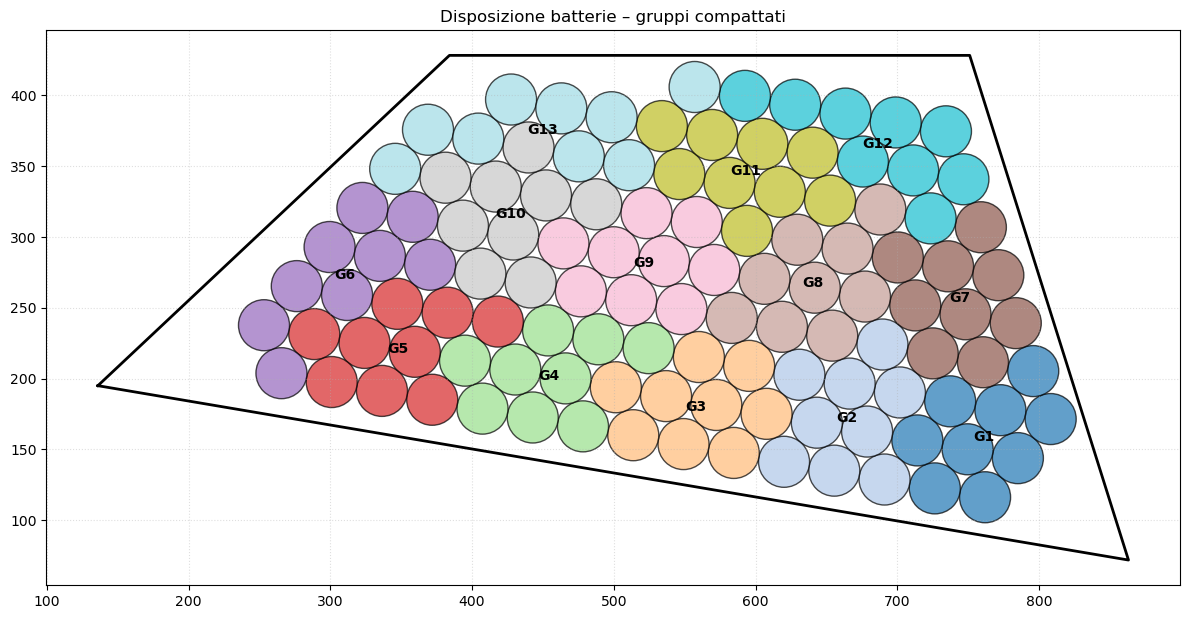

In [141]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

#######################################################################
# 1. CONFIGURATION                                                    #
#######################################################################

DIST_FACTOR = 3.5          # distanza di adiacenza = DIST_FACTOR · radius

#######################################################################
# 2. UTILITY                                                          #
#######################################################################

def calcola_configurazione_batteria(v_cella, ah_cella,
                                    v_target, ah_target,
                                    celle_disponibili):
    s = round(v_target / v_cella)
    p = round(ah_target / ah_cella)
    tot = s * p
    print(f"Configurazione suggerita: {s}S{p}P  ({tot} celle)")
    if tot <= celle_disponibili:
        print("✅ Celle sufficienti.")
    else:
        print("⚠️ Troppe celle, rivedere il target.")
    return s, p, tot


def build_adjacency_fast(centers, radius) -> nx.Graph:
    """Grafo di adiacenza con nodi = indici (più semplice & veloce)."""
    pts = np.asarray(centers)
    D = np.linalg.norm(pts[:, None, :] - pts[None, :, :], axis=-1)
    mask = (D <= DIST_FACTOR * radius) & (D > 0)

    G = nx.Graph()
    for i in range(len(centers)):
        js = np.nonzero(mask[i])[0]
        G.add_edges_from((i, int(j)) for j in js)
    return G


def elimina_celle_in_eccesso(centers, required, radius):
    if len(centers) <= required:
        return centers

    G = build_adjacency_fast(centers, radius)
    main = max(nx.connected_components(G), key=len)
    kept = list(main)

    while len(kept) > required:
        worst = min(kept, key=G.degree.__getitem__)
        kept.remove(worst)

    return [centers[i] for i in kept]

#######################################################################
# 3. GRUPPI INIZIALI (liste di INDICI)                                #
#######################################################################

def crea_gruppi_regolari(centers, S, P, radius, G):
    used = set()
    order = sorted(range(len(centers)), key=lambda i: (centers[i][1], centers[i][0]))
    gruppi_idx = []

    for seed in order:
        if seed in used:
            continue
        group = [seed]
        queue = [seed]
        used.add(seed)

        while queue and len(group) < P:
            cur = queue.pop(0)
            neigh = [n for n in G.neighbors(cur) if n not in used]
            neigh.sort(key=lambda n: np.linalg.norm(np.subtract(centers[n], centers[seed])))
            for n in neigh:
                group.append(n); used.add(n); queue.append(n)
                if len(group) == P:
                    break

        if len(group) < P:                         # riempimento con i più vicini rimasti
            rest = [i for i in order if i not in used]
            rest.sort(key=lambda n: np.linalg.norm(np.subtract(centers[n], centers[seed])))
            for n in rest[: P - len(group)]:
                group.append(n); used.add(n)

        gruppi_idx.append(group)
        if len(gruppi_idx) == S:
            break

    while len(gruppi_idx) < S:                     # in caso di mancanza nodi
        gruppi_idx.append([])

    return gruppi_idx

#######################################################################
# 4. RIPULITURA “SCHEGGE”                                              #
#######################################################################

def _is_connected(nodes: list[int], G: nx.Graph) -> bool:
    """Ritorna True se tutti i nodi sono in un’unica componente connessa."""
    if len(nodes) <= 1:          # 0-1 nodi è comunque “connesso”
        return True
    sub = G.subgraph(nodes)
    return nx.is_connected(sub)

def refine_groups(gruppi: list[list[int]],
                  P: int,
                  G: nx.Graph,
                  centers: list[tuple[float, float]],
                  max_pass: int = 8) -> list[list[int]]:
    """Elimina ‘schegge’ scambiandole con celle adiacenti del gruppo vicino.

    – una ‘scheggia’ è una cella non nello stesso componente connesso
      del corpo principale del proprio gruppo;
    – si cerca un gruppo adiacente (con un lato in comune) che abbia
      una cella da scambiare;
    – lo scambio è accettato solo se **dopo** entrambi i gruppi risultano
      connessi (o migliorano il numero di componenti).
    """
    # mappa cella → gruppo
    cell2g = {idx: gi for gi, g in enumerate(gruppi) for idx in g}

    made_changes = True
    n_pass = 0
    while made_changes and n_pass < max_pass:
        made_changes = False
        n_pass += 1

        for gi, gruppo in enumerate(gruppi):
            if _is_connected(gruppo, G):
                continue                # già coeso

            # componente “corpo” più grande
            comps = list(nx.connected_components(G.subgraph(gruppo)))
            main_comp = max(comps, key=len)
            outliers  = [c for c in gruppo if c not in main_comp]

            for cell in outliers:
                # gruppi adiacenti alla scheggia
                vicino_groups = {cell2g[n] for n in G.neighbors(cell)
                                 if cell2g[n] != gi}

                # valuta ogni gruppo vicino
                for gj in vicino_groups:
                    # scegli una candidata da gj il più possibile vicina al corpo di gi
                    cand_cells = [n for n in gruppi[gj]
                                  if any(G.has_edge(n, m) for m in main_comp)]
                    if not cand_cells:
                        continue

                    # ordinale per distanza geometrica dal centroide del corpo
                    cx, cy = np.mean([centers[m][0] for m in main_comp]), \
                             np.mean([centers[m][1] for m in main_comp])
                    cand_cells.sort(key=lambda n:
                                    np.hypot(centers[n][0] - cx,
                                             centers[n][1] - cy))

                    for donor in cand_cells:
                        # swap “cell” ↔ donor (prova virtualmente)
                        grp_i_new = [x for x in gruppi[gi] if x != cell] + [donor]
                        grp_j_new = [x for x in gruppi[gj] if x != donor] + [cell]

                        # capienza rispettata?
                        if len(grp_i_new) > P or len(grp_j_new) > P:
                            continue

                        # accetta se entrambi i gruppi diventano (o restano) connessi
                        if _is_connected(grp_i_new, G) and _is_connected(grp_j_new, G):
                            gruppi[gi] = grp_i_new
                            gruppi[gj] = grp_j_new
                            cell2g[cell]  = gj
                            cell2g[donor] = gi
                            made_changes = True
                            break     # fine donor-loop
                    if made_changes:
                        break         # fine gj-loop
            # fine for cell
        # fine per gi
    return gruppi

#######################################################################
# 5. VISUALIZZAZIONE (usa coordinate)                                  #
#######################################################################

def visualizza_gruppi(polygon, gruppi_coord, radius):
    fig, ax = plt.subplots(figsize=(12, 8))
    px, py = zip(*polygon)
    ax.plot(px, py, "k-", lw=2)

    cmap = plt.cm.get_cmap("tab20", len(gruppi_coord))
    for gid, gruppo in enumerate(gruppi_coord):
        for x, y in gruppo:
            ax.add_patch(plt.Circle((x, y), radius, color=cmap(gid), ec="black", alpha=0.7))
        if gruppo:
            gx, gy = np.mean([p[0] for p in gruppo]), np.mean([p[1] for p in gruppo])
            ax.text(gx, gy, f"G{gid+1}", ha="center", va="center", weight="bold")
    ax.set_aspect("equal"); ax.grid(ls=":", alpha=0.4)
    ax.set_title("Disposizione batterie – gruppi compattati")
    plt.tight_layout(); plt.show()

#######################################################################
# 6. MAIN                                                              #
#######################################################################

def main(json_path="polygon_with_circles.json", output_path="layout.json"):
    
    S=13
    P=9

    # dati
    data = json.loads(Path(json_path).read_text())
    centers = [tuple(c["center"]) for c in data["circles"]]
    radius  = data["circles"][0]["radius"]

    # pruning celle
    centers = elimina_celle_in_eccesso(centers, S * P, radius)

    # grafo unico
    G = build_adjacency_fast(centers, radius)

    # gruppi indici + raffinatura
    gruppi_idx = crea_gruppi_regolari(centers, S, P, radius, G)
    gruppi_idx = refine_groups(gruppi_idx, P, G, centers)

    # traduci in coordinate per output / plot
    gruppi_coord = [[centers[i] for i in g] for g in gruppi_idx]

    # salva
    Path(output_path).write_text(json.dumps({
        "polygon": data["polygon"],
        "circles": [{"center": list(c), "radius": radius} for c in centers],
        "gruppi": gruppi_coord
    }, indent=2))
    print(f"✅ Layout salvato in {output_path}")

    # mostra
    visualizza_gruppi(data["polygon"], gruppi_coord, radius)


if __name__ == "__main__":
    main()

In [ ]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

#######################################################################
# 1. CONFIGURATION                                                    #
#######################################################################

DIST_FACTOR = 3.0          # distanza di adiacenza = DIST_FACTOR · radius

#######################################################################
# 2. UTILITY                                                          #
#######################################################################

def calcola_configurazione_batteria(v_cella, ah_cella,
                                    v_target, ah_target,
                                    celle_disponibili):
    s = round(v_target / v_cella)
    p = round(ah_target / ah_cella)
    tot = s * p
    print(f"Configurazione suggerita: {s}S{p}P  ({tot} celle)")
    if tot <= celle_disponibili:
        print("✅ Celle sufficienti.")
    else:
        print("⚠️ Troppe celle, rivedere il target.")
    return s, p, tot


def build_adjacency_fast(centers, radius) -> nx.Graph:
    """Grafo di adiacenza con nodi = indici (più semplice & veloce)."""
    pts = np.asarray(centers)
    D = np.linalg.norm(pts[:, None, :] - pts[None, :, :], axis=-1)
    mask = (D <= DIST_FACTOR * radius) & (D > 0)

    G = nx.Graph()
    for i in range(len(centers)):
        js = np.nonzero(mask[i])[0]
        G.add_edges_from((i, int(j)) for j in js)
    return G


def elimina_celle_in_eccesso(centers, required, radius):
    if len(centers) <= required:
        return centers

    G = build_adjacency_fast(centers, radius)
    main = max(nx.connected_components(G), key=len)
    kept = list(main)

    while len(kept) > required:
        worst = min(kept, key=G.degree.__getitem__)
        kept.remove(worst)

    return [centers[i] for i in kept]

#######################################################################
# 3. GRUPPI INIZIALI (liste di INDICI)                                #
#######################################################################

def crea_gruppi_regolari(centers, S, P, radius, G):
    used = set()
    order = sorted(range(len(centers)), key=lambda i: (centers[i][1], centers[i][0]))
    gruppi_idx = []

    for seed in order:
        if seed in used:
            continue
        group = [seed]
        queue = [seed]
        used.add(seed)

        while queue and len(group) < P:
            cur = queue.pop(0)
            neigh = [n for n in G.neighbors(cur) if n not in used]
            cx, cy = np.mean([centers[k] for k in group], axis=0)
            neigh.sort(key=lambda n: (abs(centers[n][0]-cx) + abs(centers[n][1]-cy)))
            for n in neigh:
                group.append(n); used.add(n); queue.append(n)
                if len(group) == P:
                    break

        if len(group) < P:                         # riempimento con i più vicini rimasti
            rest = [i for i in order if i not in used]
            rest.sort(key=lambda n: np.linalg.norm(np.subtract(centers[n], centers[seed])))
            for n in rest[: P - len(group)]:
                group.append(n); used.add(n)

        gruppi_idx.append(group)
        if len(gruppi_idx) == S:
            break

    while len(gruppi_idx) < S:                     # in caso di mancanza nodi
        gruppi_idx.append([])

    return gruppi_idx

#######################################################################
# 4. RIPULITURA “SCHEGGE”                                              #
#######################################################################

def _is_connected(nodes: list[int], G: nx.Graph) -> bool:
    """Ritorna True se tutti i nodi sono in un’unica componente connessa."""
    if len(nodes) <= 1:          # 0-1 nodi è comunque “connesso”
        return True
    sub = G.subgraph(nodes)
    return nx.is_connected(sub)

def refine_groups(gruppi: list[list[int]],
                  P: int,
                  G: nx.Graph,
                  centers: list[tuple[float, float]],
                  max_pass: int = 8) -> list[list[int]]:
    """Elimina ‘schegge’ scambiandole con celle adiacenti del gruppo vicino.

    – una ‘scheggia’ è una cella non nello stesso componente connesso
      del corpo principale del proprio gruppo;
    – si cerca un gruppo adiacente (con un lato in comune) che abbia
      una cella da scambiare;
    – lo scambio è accettato solo se **dopo** entrambi i gruppi risultano
      connessi (o migliorano il numero di componenti).
    """
    # mappa cella → gruppo
    cell2g = {idx: gi for gi, g in enumerate(gruppi) for idx in g}

    made_changes = True
    n_pass = 0
    while made_changes and n_pass < max_pass:
        made_changes = False
        n_pass += 1

        for gi, gruppo in enumerate(gruppi):
            if _is_connected(gruppo, G):
                continue                # già coeso

            # componente “corpo” più grande
            comps = list(nx.connected_components(G.subgraph(gruppo)))
            main_comp = max(comps, key=len)
            outliers  = [c for c in gruppo if c not in main_comp]

            for cell in outliers:
                # gruppi adiacenti alla scheggia
                vicino_groups = {cell2g[n] for n in G.neighbors(cell)
                                 if cell2g[n] != gi}

                # valuta ogni gruppo vicino
                for gj in vicino_groups:
                    # scegli una candidata da gj il più possibile vicina al corpo di gi
                    cand_cells = [n for n in gruppi[gj]
                                  if any(G.has_edge(n, m) for m in main_comp)]
                    if not cand_cells:
                        continue

                    # ordinale per distanza geometrica dal centroide del corpo
                    cx, cy = np.mean([centers[m][0] for m in main_comp]), \
                             np.mean([centers[m][1] for m in main_comp])
                    cand_cells.sort(key=lambda n:
                                    np.hypot(centers[n][0] - cx,
                                             centers[n][1] - cy))

                    for donor in cand_cells:
                        # swap “cell” ↔ donor (prova virtualmente)
                        grp_i_new = [x for x in gruppi[gi] if x != cell] + [donor]
                        grp_j_new = [x for x in gruppi[gj] if x != donor] + [cell]

                        # capienza rispettata?
                        if len(grp_i_new) > P or len(grp_j_new) > P:
                            continue

                        # accetta se entrambi i gruppi diventano (o restano) connessi
                        if _is_connected(grp_i_new, G) and _is_connected(grp_j_new, G):
                            gruppi[gi] = grp_i_new
                            gruppi[gj] = grp_j_new
                            cell2g[cell]  = gj
                            cell2g[donor] = gi
                            made_changes = True
                            break     # fine donor-loop
                    if made_changes:
                        break         # fine gj-loop
            # fine for cell
        # fine per gi
    return gruppi

#######################################################################
# 5. VISUALIZZAZIONE (usa coordinate)                                  #
#######################################################################

def visualizza_gruppi(polygon, gruppi_coord, radius):
    fig, ax = plt.subplots(figsize=(12, 8))
    px, py = zip(*polygon)
    ax.plot(px, py, "k-", lw=2)

    cmap = plt.cm.get_cmap("tab20", len(gruppi_coord))
    for gid, gruppo in enumerate(gruppi_coord):
        for x, y in gruppo:
            ax.add_patch(plt.Circle((x, y), radius, color=cmap(gid), ec="black", alpha=0.7))
        if gruppo:
            gx, gy = np.mean([p[0] for p in gruppo]), np.mean([p[1] for p in gruppo])
            ax.text(gx, gy, f"G{gid+1}", ha="center", va="center", weight="bold")
    ax.set_aspect("equal"); ax.grid(ls=":", alpha=0.4)
    ax.set_title("Disposizione batterie – gruppi compattati")
    plt.tight_layout(); plt.show()

#######################################################################
# 6. MAIN                                                              #
#######################################################################

def main(json_path="polygon_with_circles.json", output_path="layout.json"):
    # config batterie
    S, P, _ = calcola_configurazione_batteria(
        v_cella=3.6, ah_cella=2.5, v_target=47, ah_target=22, celle_disponibili=117)
    
    S=12
    P=9

    # dati
    data = json.loads(Path(json_path).read_text())
    centers = [tuple(c["center"]) for c in data["circles"]]
    radius  = data["circles"][0]["radius"]

    # pruning celle
    centers = elimina_celle_in_eccesso(centers, S * P, radius)

    # grafo unico
    G = build_adjacency_fast(centers, radius)

    # gruppi indici + raffinatura
    gruppi_idx = crea_gruppi_regolari(centers, S, P, radius, G)
    gruppi_idx = refine_groups(gruppi_idx, P, G, centers)

    # traduci in coordinate per output / plot
    gruppi_coord = [[centers[i] for i in g] for g in gruppi_idx]

    # salva
    Path(output_path).write_text(json.dumps({
        "polygon": data["polygon"],
        "circles": [{"center": list(c), "radius": radius} for c in centers],
        "gruppi": gruppi_coord
    }, indent=2))
    print(f"✅ Layout salvato in {output_path}")

    # mostra
    visualizza_gruppi(data["polygon"], gruppi_coord, radius)


if __name__ == "__main__":
    main()

✅  Layout salvato in layout.json


/var/folders/20/448h2f1933x4jpn5p3l2lb7c0000gn/T/ipykernel_6066/2931036603.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(groups))


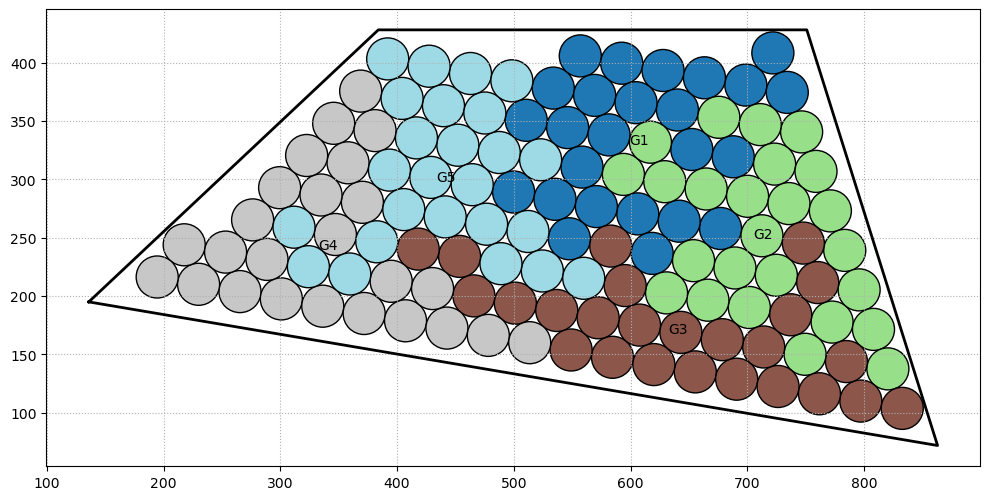

In [ ]:
# ----------------------------------------------------------
# 0. dipendenze
# pip install "spopt>=0.4,<0.7" libpysal networkx
# ----------------------------------------------------------
import json, math, random
from pathlib import Path

import numpy as np, libpysal, networkx as nx
import matplotlib.pyplot as plt
from   spopt.region import RandomRegion

DIST_FACTOR = 2.2          # raggio di adiacenza = DIST_FACTOR * radius
# pesi della funzione-obiettivo di forma (più basso = migliore)
ALPHA = 0.5 ; BETA = 0.5 ; GAMMA = 0.5                                    ### NEW

# ----------------------------------------------------------
# 1. costruzione grafo di adiacenza
# ----------------------------------------------------------
def build_graph(centers, r):
    pts  = np.asarray(centers)
    dmat = np.linalg.norm(pts[:, None] - pts[None, :], axis=-1)
    mask = (dmat > 0) & (dmat <= DIST_FACTOR * r)
    G = nx.Graph()
    for i in range(len(centers)):
        for j in np.where(mask[i])[0]:
            G.add_edge(i, int(j))
    return G

def graph_to_weights(G):
    return libpysal.weights.W({i: list(G.neighbors(i)) for i in G.nodes})

# ----------------------------------------------------------
# 2. metrica di “rettangularità”  e funzioni di utilità      ### NEW
# ----------------------------------------------------------
def shape_cost(group, centers, r):
    xs, ys = zip(*[centers[i] for i in group])
    w = max(xs) - min(xs) + 2*r
    h = max(ys) - min(ys) + 2*r
    perim = 2*(w+h)
    area  = w*h
    axis_ratio = max(w, h) / min(w, h)
    cx, cy = np.mean(xs), np.mean(ys)
    inertia = np.mean([(x-cx)**2 + (y-cy)**2 for x, y in zip(xs, ys)])
    return (ALPHA * perim/math.sqrt(area)
          +  BETA  * (axis_ratio - 1)
          +  GAMMA * inertia)

def _is_conn(nodes, G):
    return len(nodes) <= 1 or nx.is_connected(G.subgraph(nodes))

# ----------------------------------------------------------
# 3. local-search per migliorare la forma dei cluster        ### NEW
# ----------------------------------------------------------
def improve_shapes(groups, P, centers, G, r, max_iter=600):
    cell2g = {i: gi for gi, g in enumerate(groups) for i in g}

    for _ in range(max_iter):
        improved = False
        ranked = sorted(range(len(groups)),
                        key=lambda gi: shape_cost(groups[gi], centers, r),
                        reverse=True)           # dal peggiore al migliore
        for gi in ranked:
            for c in tuple(groups[gi]):         # copia perché potremmo togliere elementi
                neigh_gj = {cell2g[n] for n in G.neighbors(c) if cell2g[n] != gi}
                for gj in neigh_gj:
                    donors = [d for d in groups[gj]
                              if any(cell2g[n] == gi for n in G.neighbors(d))]
                    donors.sort(key=lambda n: G.degree[n], reverse=True)
                    for d in donors:
                        if c == d: continue
                        # swap virtuale
                        groups[gi].remove(c); groups[gi].append(d)
                        groups[gj].remove(d); groups[gj].append(c)
                        ok = _is_conn(groups[gi], G) and _is_conn(groups[gj], G)
                        better = (shape_cost(groups[gi], centers, r) +
                                  shape_cost(groups[gj], centers, r) <
                                  shape_cost(groups[gi]+[c], centers, r) +
                                  shape_cost(groups[gj]+[d], centers, r))
                        if ok and better:
                            cell2g[c], cell2g[d] = gj, gi
                            improved = True
                            break
                        # ripristina
                        groups[gi].remove(d); groups[gi].append(c)
                        groups[gj].remove(c); groups[gj].append(d)
                    if improved: break
                if improved: break
            if improved: break
        if not improved:
            break
    return groups
# ----------------------------------------------------------
# 4. algoritmo principale (spopt 0.6.x) – *uguale a prima*   #
# ----------------------------------------------------------
def regionalize(centers, r, S, P, seed=0, max_attempts=50):
    ids = list(range(len(centers)))
    W_dict = {i: [] for i in ids}
    for i, c1 in enumerate(centers):
        for j, c2 in enumerate(centers):
            if i != j and np.linalg.norm(np.subtract(c1, c2)) <= DIST_FACTOR * r:
                W_dict[i].append(j)
    W = libpysal.weights.W(W_dict)

    cards = [P] * S
    np.random.seed(seed)

    for _ in range(max_attempts):
        rr = RandomRegion(
            area_ids   = ids,
            num_regions= S,
            cardinality= cards,
            contiguity = W,
            maxiter    = 500,
            compact    = True
        )
        if rr.feasible:
            return rr.regions
    raise RuntimeError("Impossibile trovare un partizionamento S×P contiguo.")

# ----------------------------------------------------------
# 5. plotting (opzionale)
# ----------------------------------------------------------
def plot(poly, groups, centers, r):
    fig, ax = plt.subplots(figsize=(10, 7))
    x, y = zip(*poly); ax.plot(x, y, "k-", lw=2)
    cmap = plt.cm.get_cmap("tab20", len(groups))
    for gi, g in enumerate(groups):
        for i in g:
            ax.add_patch(plt.Circle(centers[i], r, color=cmap(gi), ec="k"))
        cx = np.mean([centers[i][0] for i in g])
        cy = np.mean([centers[i][1] for i in g])
        ax.text(cx, cy, f"G{gi+1}", ha="center", va="center")
    ax.set_aspect("equal"); ax.grid(ls=":"); plt.tight_layout(); plt.show()

# ----------------------------------------------------------
# 6. main
# ----------------------------------------------------------
def main(inp="polygon_with_circles.json",
         out="layout.json",
         v_cell=3.6, ah_cell=2.5,      # dati batteria
         v_tgt =18, ah_tgt =62.5,    # 9 S, 12 P
         show=True):

    data    = json.loads(Path(inp).read_text())
    centers = [tuple(c["center"]) for c in data["circles"]]
    r       = data["circles"][0]["radius"]

    S = round(v_tgt / v_cell)
    P = round(ah_tgt / ah_cell)
    assert S * P == len(centers), "Numero di celle ≠ S×P!"

    # partizionamento contiguo (spopt)
    groups  = regionalize(centers, r, S, P)

    # grafico di adiacenza per la fase di miglioramento
    G = build_graph(centers, r)
    groups = improve_shapes(groups, P, centers, G, r)                ### NEW

    # controllo finale
    assert len(groups)==S and all(len(g)==P for g in groups)

    # salva
    Path(out).write_text(json.dumps({
        "polygon": data["polygon"],
        "circles": data["circles"],
        "gruppi" : [[centers[i] for i in g] for g in groups]
    }, indent=2))
    print("✅  Layout salvato in", out)

    if show:
        plot(data["polygon"], groups, centers, r)

# ----------------------------------------------------------
if __name__ == "__main__":
    main()

In [78]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

#######################################################################
# 1. CONFIGURATION                                                    #
#######################################################################

DIST_FACTOR = 3.0          # distanza di adiacenza = DIST_FACTOR · radius

#######################################################################
# 2. UTILITY                                                          #
#######################################################################

def calcola_configurazione_batteria(v_cella, ah_cella,
                                    v_target, ah_target,
                                    celle_disponibili):
    s = round(v_target / v_cella)
    p = round(ah_target / ah_cella)
    tot = s * p
    print(f"Configurazione suggerita: {s}S{p}P  ({tot} celle)")
    if tot <= celle_disponibili:
        print("✅ Celle sufficienti.")
    else:
        print("⚠️ Troppe celle, rivedere il target.")
    return s, p, tot


def build_adjacency_fast(centers, radius) -> nx.Graph:
    """Grafo di adiacenza con nodi = indici (più semplice & veloce)."""
    pts = np.asarray(centers)
    D = np.linalg.norm(pts[:, None, :] - pts[None, :, :], axis=-1)
    mask = (D <= DIST_FACTOR * radius) & (D > 0)

    G = nx.Graph()
    for i in range(len(centers)):
        js = np.nonzero(mask[i])[0]
        G.add_edges_from((i, int(j)) for j in js)
    return G


def elimina_celle_in_eccesso(centers, required, radius):
    if len(centers) <= required:
        return centers

    G = build_adjacency_fast(centers, radius)
    main = max(nx.connected_components(G), key=len)
    kept = list(main)

    while len(kept) > required:
        worst = min(kept, key=G.degree.__getitem__)
        kept.remove(worst)

    return [centers[i] for i in kept]

#######################################################################
# 3. GRUPPI INIZIALI (liste di INDICI)                                #
#######################################################################


def seleziona_seed(centers, S, radius, polygon, max_iter=500, repulsion_factor=1.0):
    import random
    import numpy as np
    from shapely.geometry import Point, Polygon

    poly = Polygon(polygon)
    num_centers = len(centers)

    # 1. Posiziona S seed casualmente all'interno del poligono
    seeds = []
    while len(seeds) < S:
        candidate = random.choice(centers)
        if Point(candidate).within(poly):
            seeds.append(candidate)

    # 2. Applica forze repulsive per distribuire i seed in modo bilanciato
    for _ in range(max_iter):
        displacements = np.zeros((S, 2))

        # Calcola le forze repulsive
        for i in range(S):
            for j in range(S):
                if i == j:
                    continue
                dist_vector = np.array(seeds[i]) - np.array(seeds[j])
                dist = np.linalg.norm(dist_vector)
                if dist > 0:
                    force = repulsion_factor / dist**2
                    displacements[i] += (dist_vector / dist) * force

        # Applica gli spostamenti
        for i in range(S):
            new_pos = np.array(seeds[i]) + displacements[i]
            if Point(new_pos).within(poly):
                seeds[i] = tuple(new_pos)

    # 3. Trova gli indici dei seed originali più vicini alle posizioni finali
    seed_indices = []
    for seed in seeds:
        closest_idx = min(range(num_centers), key=lambda idx: np.linalg.norm(np.array(centers[idx]) - np.array(seed)))
        if closest_idx not in seed_indices:
            seed_indices.append(closest_idx)

    # Verifica che abbiamo esattamente S seed
    if len(seed_indices) < S:
        remaining = [i for i in range(num_centers) if i not in seed_indices]
        seed_indices += remaining[:S - len(seed_indices)]

    return seed_indices

def crea_gruppi_regolari(centers, S, P, radius, G, polygon):
    used = set()
    order = seleziona_seed(centers, S, radius, polygon, max_iter=500, repulsion_factor=1.0)
    gruppi_idx = []

    for seed in order:
        if seed in used:
            continue
        group = [seed]
        queue = [seed]
        used.add(seed)

        while queue and len(group) < P:
            cur = queue.pop(0)
            neigh = [n for n in G.neighbors(cur) if n not in used]
            neigh.sort(key=lambda n: np.linalg.norm(np.subtract(centers[n], centers[seed])))
            for n in neigh:
                group.append(n); used.add(n); queue.append(n)
                if len(group) == P:
                    break

        if len(group) < P:                         # riempimento con i più vicini rimasti
            rest = [i for i in order if i not in used]
            rest.sort(key=lambda n: np.linalg.norm(np.subtract(centers[n], centers[seed])))
            for n in rest[: P - len(group)]:
                group.append(n); used.add(n)

        gruppi_idx.append(group)
        if len(gruppi_idx) == S:
            break

    while len(gruppi_idx) < S:                     # in caso di mancanza nodi
        gruppi_idx.append([])

    return gruppi_idx

#######################################################################
# 4. RIPULITURA “SCHEGGE”                                              #
#######################################################################

def _is_connected(nodes: list[int], G: nx.Graph) -> bool:
    """Ritorna True se tutti i nodi sono in un’unica componente connessa."""
    if len(nodes) <= 1:          # 0-1 nodi è comunque “connesso”
        return True
    sub = G.subgraph(nodes)
    return nx.is_connected(sub)

def refine_groups(gruppi: list[list[int]],
                  P: int,
                  G: nx.Graph,
                  centers: list[tuple[float, float]],
                  max_pass: int = 8) -> list[list[int]]:
    """Elimina ‘schegge’ scambiandole con celle adiacenti del gruppo vicino.

    – una ‘scheggia’ è una cella non nello stesso componente connesso
      del corpo principale del proprio gruppo;
    – si cerca un gruppo adiacente (con un lato in comune) che abbia
      una cella da scambiare;
    – lo scambio è accettato solo se **dopo** entrambi i gruppi risultano
      connessi (o migliorano il numero di componenti).
    """
    # mappa cella → gruppo
    cell2g = {idx: gi for gi, g in enumerate(gruppi) for idx in g}

    made_changes = True
    n_pass = 0
    while made_changes and n_pass < max_pass:
        made_changes = False
        n_pass += 1

        for gi, gruppo in enumerate(gruppi):
            if _is_connected(gruppo, G):
                continue                # già coeso

            # componente “corpo” più grande
            comps = list(nx.connected_components(G.subgraph(gruppo)))
            main_comp = max(comps, key=len)
            outliers  = [c for c in gruppo if c not in main_comp]

            for cell in outliers:
                # gruppi adiacenti alla scheggia
                vicino_groups = {cell2g[n] for n in G.neighbors(cell)
                                 if cell2g[n] != gi}

                # valuta ogni gruppo vicino
                for gj in vicino_groups:
                    # scegli una candidata da gj il più possibile vicina al corpo di gi
                    cand_cells = [n for n in gruppi[gj]
                                  if any(G.has_edge(n, m) for m in main_comp)]
                    if not cand_cells:
                        continue

                    # ordinale per distanza geometrica dal centroide del corpo
                    cx, cy = np.mean([centers[m][0] for m in main_comp]), \
                             np.mean([centers[m][1] for m in main_comp])
                    cand_cells.sort(key=lambda n:
                                    np.hypot(centers[n][0] - cx,
                                             centers[n][1] - cy))

                    for donor in cand_cells:
                        # swap “cell” ↔ donor (prova virtualmente)
                        grp_i_new = [x for x in gruppi[gi] if x != cell] + [donor]
                        grp_j_new = [x for x in gruppi[gj] if x != donor] + [cell]

                        # capienza rispettata?
                        if len(grp_i_new) > P or len(grp_j_new) > P:
                            continue

                        # accetta se entrambi i gruppi diventano (o restano) connessi
                        if _is_connected(grp_i_new, G) and _is_connected(grp_j_new, G):
                            gruppi[gi] = grp_i_new
                            gruppi[gj] = grp_j_new
                            cell2g[cell]  = gj
                            cell2g[donor] = gi
                            made_changes = True
                            break     # fine donor-loop
                    if made_changes:
                        break         # fine gj-loop
            # fine for cell
        # fine per gi
    return gruppi

#######################################################################
# 5. VISUALIZZAZIONE (usa coordinate)                                  #
#######################################################################

def visualizza_gruppi(polygon, gruppi_coord, radius):
    fig, ax = plt.subplots(figsize=(12, 8))
    px, py = zip(*polygon)
    ax.plot(px, py, "k-", lw=2)

    cmap = plt.cm.get_cmap("tab20", len(gruppi_coord))
    for gid, gruppo in enumerate(gruppi_coord):
        for x, y in gruppo:
            ax.add_patch(plt.Circle((x, y), radius, color=cmap(gid), ec="black", alpha=0.7))
        if gruppo:
            gx, gy = np.mean([p[0] for p in gruppo]), np.mean([p[1] for p in gruppo])
            ax.text(gx, gy, f"G{gid+1}", ha="center", va="center", weight="bold")
    ax.set_aspect("equal"); ax.grid(ls=":", alpha=0.4)
    ax.set_title("Disposizione batterie – gruppi compattati")
    plt.tight_layout(); plt.show()

#######################################################################
# 6. MAIN                                                              #
#######################################################################

def main(json_path="polygon_with_circles.json", output_path="layout.json"):
    # config batterie
    S, P, _ = calcola_configurazione_batteria(
        v_cella=3.6, ah_cella=2.5, v_target=32.40, ah_target=30, celle_disponibili=108)
    
    S=19
    P=5

    # dati
    data = json.loads(Path(json_path).read_text())
    centers = [tuple(c["center"]) for c in data["circles"]]
    radius  = data["circles"][0]["radius"]

    # pruning celle
    centers = elimina_celle_in_eccesso(centers, S * P, radius)

    # grafo unico
    G = build_adjacency_fast(centers, radius)

    # gruppi indici + raffinatura
    gruppi_idx = crea_gruppi_regolari(centers, S, P, radius, G, data["polygon"])
    gruppi_idx = refine_groups(gruppi_idx, P, G, centers)

    # traduci in coordinate per output / plot
    gruppi_coord = [[centers[i] for i in g] for g in gruppi_idx]

    # salva
    Path(output_path).write_text(json.dumps({
        "polygon": data["polygon"],
        "circles": [{"center": list(c), "radius": radius} for c in centers],
        "gruppi": gruppi_coord
    }, indent=2))
    print(f"✅ Layout salvato in {output_path}")

    # mostra
    visualizza_gruppi(data["polygon"], gruppi_coord, radius)


if __name__ == "__main__":
    main()

Configurazione suggerita: 9S12P  (108 celle)
✅ Celle sufficienti.


KeyError: 80

In [59]:
# circle_graph_partition.py
"""Balanced connected partitioning of a graph of touching circles.

Modifiche richieste dall'utente (maggio 2025)
------------------------------------------------
1. **Il grafo viene salvato** nello *stesso* file JSON (o in un file di
   output indicato) sotto la chiave ``"graph"`` con:
   - ``"edges"``: lista di coppie di indici dei nodi che si toccano;
   - ``"partitions"``: dizionario {id_partizione: [lista_nodi]}.
2. I parametri *S*, *P*, *input_path* e *output_path* si impostano
   direttamente nella funzione ``main`` (nessuna CLI obbligatoria—anche se
   la teniamo opzionale).

Dipendenze: ``networkx>=3.0``, ``matplotlib``.
"""

from __future__ import annotations

import json
import math
from itertools import combinations
from pathlib import Path
from typing import Dict, List, Sequence, Set

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import networkx as nx

###############################################################################
# STEP 1 – Build the graph from JSON                                         #
###############################################################################

def build_graph_from_json(path: str | Path, tol: float = 1e-8) -> nx.Graph:
    """Legge *path* (``str`` o ``Path``) e restituisce il grafo NetworkX.

    Due cerchi sono adiacenti se la distanza fra i centri ≤ 2×raggio (+tol).
    Tutti i cerchi si assume abbiano lo *stesso* raggio; se ne manca qualcuno,
    usiamo il raggio del primo.
    """

    with open(path, "r", encoding="utf-8") as fh:
        data: Dict = json.load(fh)

    circles: List[Dict] = data["circles"]
    if not circles:
        raise ValueError("Il file JSON non contiene cerchi → niente da fare.")

    default_r = circles[0].get("radius")

    G = nx.Graph()
    for idx, c in enumerate(circles):
        cx, cy = c["center"]
        r = c.get("radius", default_r)
        G.add_node(idx, center=(cx, cy), radius=r)

    for (i, ci), (j, cj) in combinations(enumerate(circles), 2):
        r = ci.get("radius", default_r)
        dx = ci["center"][0] - cj["center"][0]
        dy = ci["center"][1] - cj["center"][1]
        if math.hypot(dx, dy) <= 2 * r + tol:
            G.add_edge(i, j)

    return G

###############################################################################
# STEP 2 – Heuristic partitioning (Seed‑&‑Grow + Refinement)                 #
###############################################################################

def greedy_connected_partition(
    G: nx.Graph, k: int, p: int, max_idle_iter: int = 10
) -> List[Set[int]]:
    """Restituisce *k* insiemi connessi di dimensione esatta *p*.
    Heuristica O(|E|) descritta in precedenza.
    """

    if k * p != G.number_of_nodes():
        raise ValueError("k * p deve essere |V| (numero di nodi totali).")

    # 1) Semina i nodi con grado più alto
    unassigned: Set[int] = set(G.nodes())
    seeds = sorted(unassigned, key=G.degree, reverse=True)[:k]

    # riserva subito tutti i seed per evitare che vengano “rubati”
    unassigned.difference_update(seeds)

    # lista delle partizioni da riempire
    parts: List[Set[int]] = []

    for s in seeds:
        part = {s}
        # il seed è già stato rimosso da `unassigned` con difference_update()

        # Crescita BFS "densità‑first"
        while len(part) < p:
            candidates = [v for u in part for v in G.neighbors(u) if v in unassigned]
            if candidates:
                v = max(candidates, key=lambda v_: sum(1 for n in G.neighbors(v_) if n in part))
            else:
                v = unassigned.pop()
            part.add(v)
            unassigned.discard(v)
        parts.append(part)

    # 2) Assegna eventuali nodi rimasti (dovrebbe essere vuoto)
    while unassigned:
        v = unassigned.pop()
        best = max(parts, key=lambda p_: sum(1 for n in G.neighbors(v) if n in p_))
        best.add(v)

    # 3) Refinement (swap 1⇄1)

    def swap_gain(a: int, A: Set[int], b: int, B: Set[int]) -> int:
        def delta(v: int, src: Set[int], dst: Set[int]) -> int:
            return sum(1 for n in G.neighbors(v) if n in dst) - sum(1 for n in G.neighbors(v) if n in src)
        return delta(a, A, B) + delta(b, B, A)

    idle = 0
    while idle < max_idle_iter:
        improved = False
        for i in range(k):
            for j in range(i + 1, k):
                A, B = parts[i], parts[j]
                for a in tuple(A):
                    for b in tuple(B):
                        if swap_gain(a, A, b, B) > 0:
                            A.remove(a); B.remove(b); A.add(b); B.add(a)
                            if nx.is_connected(G.subgraph(A)) and nx.is_connected(G.subgraph(B)):
                                improved = True
                            else:
                                # rollback
                                A.remove(b); B.remove(a); A.add(a); B.add(b)
                if improved:
                    break
            if improved:
                break
        idle = 0 if improved else idle + 1
    return parts

###############################################################################
# STEP 3 – Salvataggio del grafo + partizioni nello stesso JSON               #
###############################################################################

def save_graph_to_json(
    data: Dict,
    G: nx.Graph,
    parts: Sequence[Set[int]],
    output_path: str | Path,
):
    """Scrive ``data`` aggiungendo la chiave "graph" e salva su *output_path*."""

    edges_out = [[int(u), int(v)] for u, v in G.edges()]
    partitions_out = {str(i): sorted(int(v) for v in part) for i, part in enumerate(parts)}

    data["graph"] = {"edges": edges_out, "partitions": partitions_out}

    with open(output_path, "w", encoding="utf-8") as fh:
        json.dump(data, fh, indent=2, sort_keys=False)

###############################################################################
# STEP 4 – Visualizzazione                                                   #
###############################################################################

def draw_partitions(
    G: nx.Graph,
    parts: Sequence[Set[int]],
    show_edges: bool = False,
    palette: str = "tab20",
    alpha: float = 0.65,
):
    cmap = plt.get_cmap(palette, len(parts))
    fig, ax = plt.subplots()

    for idx, part in enumerate(parts):
        colour = cmap(idx)
        for v in part:
            (x, y) = G.nodes[v]["center"]
            r = G.nodes[v]["radius"]
            circ = mpatches.Circle((x, y), r, facecolor=colour, edgecolor="black", lw=0.5, alpha=alpha)
            ax.add_patch(circ)
        if show_edges:
            for u, v in G.subgraph(part).edges():
                x1, y1 = G.nodes[u]["center"]
                x2, y2 = G.nodes[v]["center"]
                ax.plot([x1, x2], [y1, y2], lw=0.4, color="black")

    ax.set_aspect("equal"); ax.set_axis_off(); plt.tight_layout(); plt.show()

###############################################################################
# STEP 5 – Funzione main «parametrica»                                       #
###############################################################################

def main(
    input_path: str = "circles.json",
    output_path: str = "circles_with_graph.json",
    k: int = 4,
    p: int | None = None,
    show_edges: bool = False,
):
    """Esegue l'intero flusso con parametri impostabili nel codice."""

    # 1) Costruisci il grafo
    G = build_graph_from_json(input_path)

    # 2) Determina p se non specificato
    n = G.number_of_nodes()
    if p is None:
        if n % k != 0:
            raise ValueError(f"|V|={n} non divisibile per k={k}; specifica p esplicitamente.")
        p = n // k
    else:
        if k * p != n:
            raise ValueError(f"k*p={k*p} deve essere |V|={n}.")

    # 3) Partiziona
    parts = greedy_connected_partition(G, k, p)

    # 4) Salva nello stesso JSON (o nuovo path)
    with open(input_path, "r", encoding="utf-8") as fh:
        data = json.load(fh)
    save_graph_to_json(data, G, parts, output_path)
    print(f"👉  Grafo e partizioni salvati in '{output_path}'.")

    # 5) Visualizza
    draw_partitions(G, parts, show_edges=show_edges)

###############################################################################
# Esecuzione «script» con valori di default (facilmente modificabili)         #
###############################################################################

if __name__ == "__main__":
    # Modifica qui i tuoi parametri; nessuna riga di comando necessaria.
    main(
        input_path="polygon_with_circles.json",       # <— file di cerchi di partenza
        output_path="layout.json",     # <— file arricchito con grafo
        k=6,                            # S partizioni
        p=23,                         # P (None ⇒ |V|/k)
        show_edges=False,               # True per disegnare archi interni
    )


KeyError: 32

✅ Layout salvato in layout.json


/var/folders/20/448h2f1933x4jpn5p3l2lb7c0000gn/T/ipykernel_8809/67075417.py:235: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(gruppi_coord))


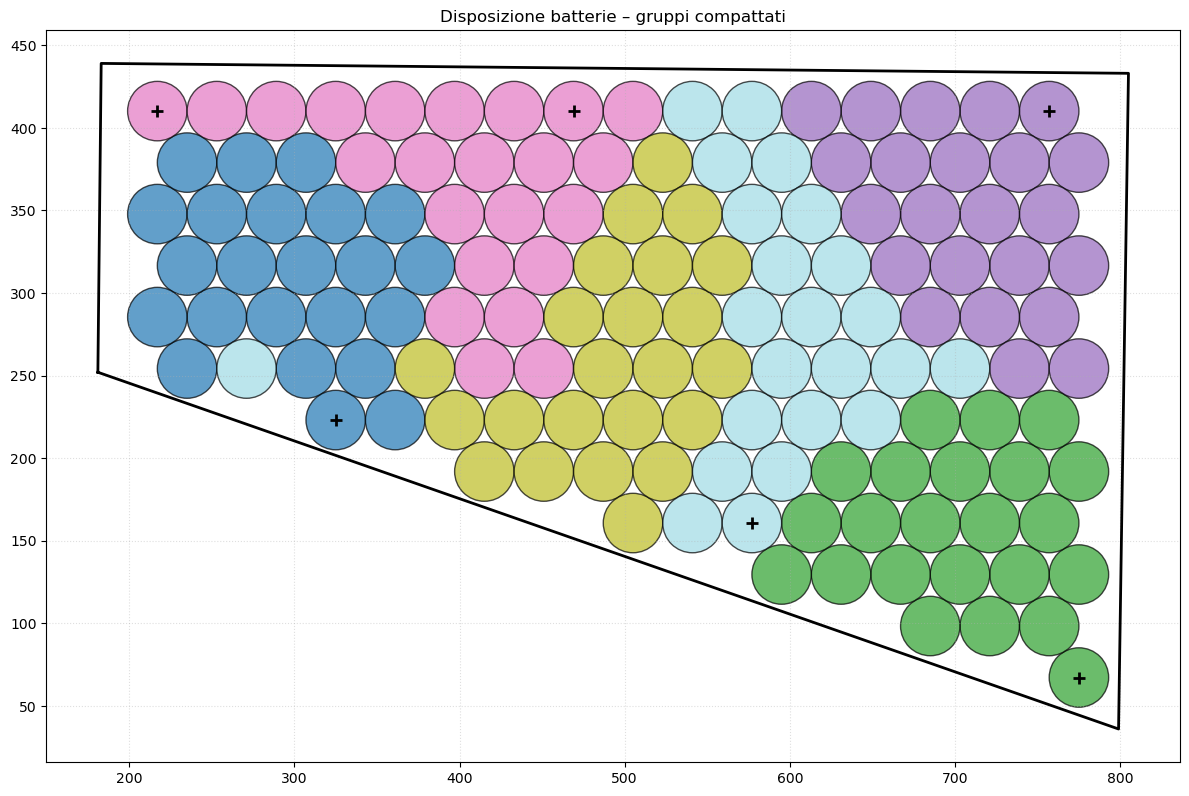

In [131]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

#######################################################################
# 1. CONFIGURATION                                                    #
#######################################################################

DIST_FACTOR = 3.0          # distanza di adiacenza = DIST_FACTOR · radius

#######################################################################
# 2. UTILITY                                                          #
#######################################################################

def calcola_configurazione_batteria(v_cella, ah_cella,
                                    v_target, ah_target,
                                    celle_disponibili):
    s = round(v_target / v_cella)
    p = round(ah_target / ah_cella)
    tot = s * p
    print(f"Configurazione suggerita: {s}S{p}P  ({tot} celle)")
    if tot <= celle_disponibili:
        print("✅ Celle sufficienti.")
    else:
        print("⚠️ Troppe celle, rivedere il target.")
    return s, p, tot


def build_adjacency_fast(centers, radius) -> nx.Graph:
    """Grafo di adiacenza con nodi = indici (più semplice & veloce)."""
    pts = np.asarray(centers)
    D = np.linalg.norm(pts[:, None, :] - pts[None, :, :], axis=-1)
    mask = (D <= DIST_FACTOR * radius) & (D > 0)

    G = nx.Graph()
    for i in range(len(centers)):
        js = np.nonzero(mask[i])[0]
        G.add_edges_from((i, int(j)) for j in js)
    return G


def elimina_celle_in_eccesso(centers, required, radius):
    if len(centers) <= required:
        return centers

    G = build_adjacency_fast(centers, radius)
    main = max(nx.connected_components(G), key=len)
    kept = list(main)

    while len(kept) > required:
        worst = min(kept, key=G.degree.__getitem__)
        kept.remove(worst)

    return [centers[i] for i in kept]

# ------------------------------------------------------------------
# 3-bis  CREAZIONE GRUPPI “REGOLARI” con controllo seed              #
# ------------------------------------------------------------------
def pick_seeds_farthest(centers, S, rng_seed=0):
    """
    Restituisce una lista di S indici scelti con il criterio ‘farthest-point’.
    Garantisce la massima distanza minima fra seed.
    """
    rng = np.random.default_rng(rng_seed)
    idx_all = np.arange(len(centers))

    # ① primo seed a caso
    first = int(rng.choice(idx_all))
    seeds = [first]

    # ② iterativamente: scegli sempre il punto più distante dal seed più vicino
    while len(seeds) < S:
        # distanza del punto i dal seme più vicino
        d_min = []
        for i, c in enumerate(centers):
            d = min(np.linalg.norm(np.subtract(c, centers[j])) for j in seeds)
            d_min.append(d)
        seeds.append(int(np.argmax(d_min)))

    return seeds


def crea_gruppi_bordo(centers, S, P, radius, G):
    from shapely.geometry import Point, LineString

    used = set()
    gruppi_idx = []

    # bounding box
    xs = [c[0] for c in centers]
    ys = [c[1] for c in centers]
    minx, maxx = min(xs), max(xs)
    miny, maxy = min(ys), max(ys)

    # perimetro: top, right, bottom, left
    border_path = (
        [(x, miny) for x in np.linspace(minx, maxx, S//4 + 1)] +
        [(maxx, y) for y in np.linspace(miny, maxy, S//4 + 1)[1:]] +
        [(x, maxy) for x in np.linspace(maxx, minx, S//4 + 1)[1:]] +
        [(minx, y) for y in np.linspace(maxy, miny, S - 3*(S//4) + 1)[1:]]
    )

    # trova i seed più vicini a quei punti
    pts = np.array(centers)
    seeds = []
    for bx, by in border_path[:S]:
        dists = np.linalg.norm(pts - np.array([bx, by]), axis=1)
        candidates = [i for i in np.argsort(dists) if i not in used]
        for c in candidates:
            if c not in used:
                seeds.append(c)
                used.add(c)
                break

    for seed in seeds:
        group = [seed]
        queue = [seed]
        used.add(seed)

        while queue and len(group) < P:
            cur = queue.pop(0)
            neigh = [n for n in G.neighbors(cur) if n not in used]
            neigh.sort(key=lambda n: np.linalg.norm(np.subtract(centers[n], centers[seed])))
            for n in neigh:
                group.append(n); used.add(n); queue.append(n)
                if len(group) == P:
                    break

        if len(group) < P:
            rest = [i for i in range(len(centers)) if i not in used]
            rest.sort(key=lambda n: np.linalg.norm(np.subtract(centers[n], centers[seed])))
            for n in rest[:P - len(group)]:
                group.append(n); used.add(n)

        gruppi_idx.append(group)

    return gruppi_idx

#######################################################################
# 4. RIPULITURA “SCHEGGE”                                              #
#######################################################################

def _is_connected(nodes: list[int], G: nx.Graph) -> bool:
    """Ritorna True se tutti i nodi sono in un’unica componente connessa."""
    if len(nodes) <= 1:          # 0-1 nodi è comunque “connesso”
        return True
    sub = G.subgraph(nodes)
    return nx.is_connected(sub)

def refine_groups(gruppi: list[list[int]],
                  P: int,
                  G: nx.Graph,
                  centers: list[tuple[float, float]],
                  max_pass: int = 8) -> list[list[int]]:
    """Elimina ‘schegge’ scambiandole con celle adiacenti del gruppo vicino.

    – una ‘scheggia’ è una cella non nello stesso componente connesso
      del corpo principale del proprio gruppo;
    – si cerca un gruppo adiacente (con un lato in comune) che abbia
      una cella da scambiare;
    – lo scambio è accettato solo se **dopo** entrambi i gruppi risultano
      connessi (o migliorano il numero di componenti).
    """
    # mappa cella → gruppo
    cell2g = {idx: gi for gi, g in enumerate(gruppi) for idx in g}

    made_changes = True
    n_pass = 0
    while made_changes and n_pass < max_pass:
        made_changes = False
        n_pass += 1

        for gi, gruppo in enumerate(gruppi):
            if _is_connected(gruppo, G):
                continue                # già coeso

            # componente “corpo” più grande
            comps = list(nx.connected_components(G.subgraph(gruppo)))
            main_comp = max(comps, key=len)
            outliers  = [c for c in gruppo if c not in main_comp]

            for cell in outliers:
                # gruppi adiacenti alla scheggia
                vicino_groups = {cell2g[n] for n in G.neighbors(cell)
                                 if cell2g[n] != gi}

                # valuta ogni gruppo vicino
                for gj in vicino_groups:
                    # scegli una candidata da gj il più possibile vicina al corpo di gi
                    cand_cells = [n for n in gruppi[gj]
                                  if any(G.has_edge(n, m) for m in main_comp)]
                    if not cand_cells:
                        continue

                    # ordinale per distanza geometrica dal centroide del corpo
                    cx, cy = np.mean([centers[m][0] for m in main_comp]), \
                             np.mean([centers[m][1] for m in main_comp])
                    cand_cells.sort(key=lambda n:
                                    np.hypot(centers[n][0] - cx,
                                             centers[n][1] - cy))

                    for donor in cand_cells:
                        # swap “cell” ↔ donor (prova virtualmente)
                        grp_i_new = [x for x in gruppi[gi] if x != cell] + [donor]
                        grp_j_new = [x for x in gruppi[gj] if x != donor] + [cell]

                        # capienza rispettata?
                        if len(grp_i_new) > P or len(grp_j_new) > P:
                            continue

                        # accetta se entrambi i gruppi diventano (o restano) connessi
                        if _is_connected(grp_i_new, G) and _is_connected(grp_j_new, G):
                            gruppi[gi] = grp_i_new
                            gruppi[gj] = grp_j_new
                            cell2g[cell]  = gj
                            cell2g[donor] = gi
                            made_changes = True
                            break     # fine donor-loop
                    if made_changes:
                        break         # fine gj-loop
            # fine for cell
        # fine per gi
    return gruppi

#######################################################################
# 5. VISUALIZZAZIONE (usa coordinate)                                  #
#######################################################################

def visualizza_gruppi(polygon, gruppi_coord, radius, seed_coord=None):
    fig, ax = plt.subplots(figsize=(12, 8))
    px, py = zip(*polygon); ax.plot(px, py, "k-", lw=2)

    cmap = plt.cm.get_cmap("tab20", len(gruppi_coord))
    for gid, gruppo in enumerate(gruppi_coord):
        for x, y in gruppo:
            ax.add_patch(plt.Circle((x, y), radius,
                          color=cmap(gid), ec="black", alpha=0.7))
    # disegna i seed come “✚”
    if seed_coord is not None:
        sx, sy = zip(*seed_coord)
        ax.scatter(sx, sy, marker="+", c="k", s=80, linewidths=2)

    ax.set_aspect("equal"); ax.grid(ls=":", alpha=0.4)
    ax.set_title("Disposizione batterie – gruppi compattati")
    plt.tight_layout(); plt.show()

#######################################################################
# 6. MAIN                                                              #
#######################################################################

def main(json_path="polygon_with_circles.json", output_path="layout.json"):
    
    S=6
    P=23

    # dati
    data = json.loads(Path(json_path).read_text())
    centers = [tuple(c["center"]) for c in data["circles"]]
    radius  = data["circles"][0]["radius"]

    # pruning celle
    centers = elimina_celle_in_eccesso(centers, S * P, radius)

    # grafo unico
    G = build_adjacency_fast(centers, radius)

    gruppi_idx = crea_gruppi_bordo(centers, S, P, radius, G,)
    seed_coord = [centers[i] for i in pick_seeds_farthest(centers, S, 42)]
    gruppi_idx = refine_groups(gruppi_idx, P, G, centers)

    # traduci in coordinate per output / plot
    gruppi_coord = [[centers[i] for i in g] for g in gruppi_idx]

    # salva
    Path(output_path).write_text(json.dumps({
        "polygon": data["polygon"],
        "circles": [{"center": list(c), "radius": radius} for c in centers],
        "gruppi": gruppi_coord
    }, indent=2))
    print(f"✅ Layout salvato in {output_path}")

    # mostra
    visualizza_gruppi(data["polygon"],
                  [[centers[i] for i in g] for g in gruppi_idx],
                  radius,
                  seed_coord)


if __name__ == "__main__":
    main()

✅ Layout salvato in polygon_with_circles_and_groups.json


/var/folders/20/448h2f1933x4jpn5p3l2lb7c0000gn/T/ipykernel_29030/3150492187.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(groups))


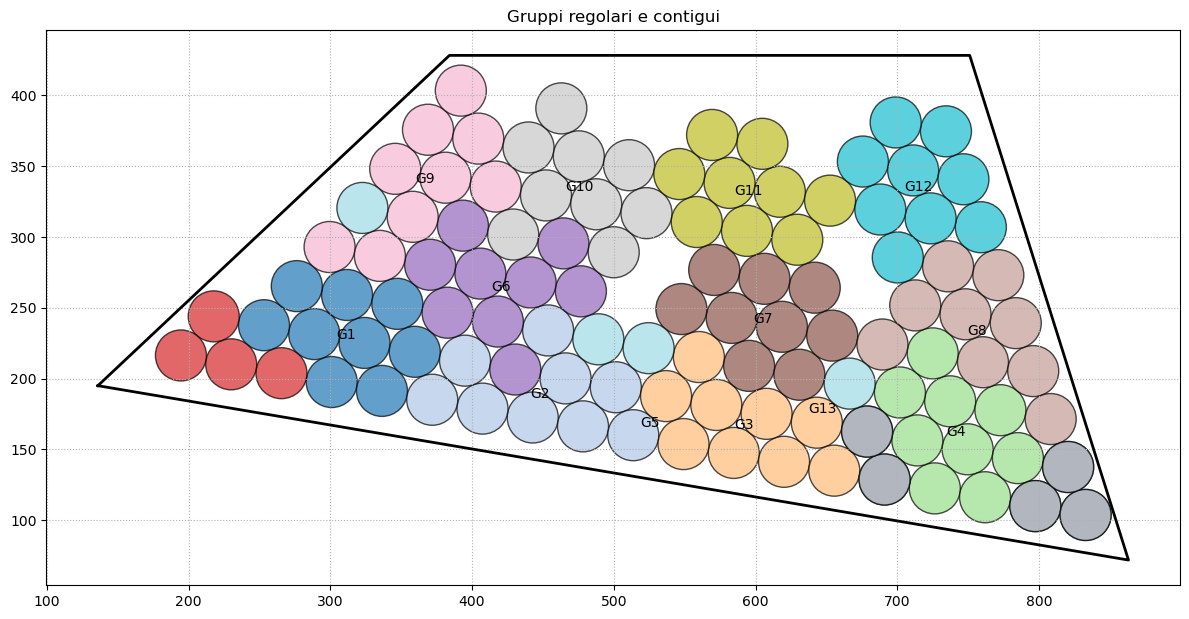

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path
from scipy.spatial import cKDTree

DIST_FACTOR = 3.0

def load_data(path):
    with open(path) as f:
        data = json.load(f)
    centers = [tuple(c["center"]) for c in data["circles"]]
    radius = data["circles"][0]["radius"]
    polygon = data["polygon"]
    return centers, radius, polygon

def build_graph(centers, radius):
    pts = np.array(centers)
    dists = np.linalg.norm(pts[:, None] - pts[None, :], axis=-1)
    G = nx.Graph()
    for i in range(len(centers)):
        for j in np.where((dists[i] <= DIST_FACTOR * radius) & (dists[i] > 0))[0]:
            G.add_edge(i, int(j))
    return G

def select_well_spaced_seeds(centers, S):
    """Sceglie S seed ben distribuiti su una griglia regolare."""
    pts = np.array(centers)
    minx, miny = np.min(pts, axis=0)
    maxx, maxy = np.max(pts, axis=0)

    cols = int(np.ceil(np.sqrt(S)))
    rows = int(np.ceil(S / cols))
    grid_w = (maxx - minx) / cols
    grid_h = (maxy - miny) / rows

    seeds = []
    used_indices = set()

    for i in range(rows):
        for j in range(cols):
            cx = minx + (j + 0.5) * grid_w
            cy = miny + (i + 0.5) * grid_h
            # trova la cella più vicina al centro della griglia
            dists = [np.hypot(x - cx, y - cy) for idx, (x, y) in enumerate(centers) if idx not in used_indices]
            if not dists:
                continue
            idx = np.argmin(dists)
            chosen = [i for i in range(len(centers)) if i not in used_indices][idx]
            seeds.append(chosen)
            used_indices.add(chosen)
            if len(seeds) == S:
                return seeds
    return seeds  # in caso non si raggiungesse S

def grow_groups_bfs(centers, radius, S, P):
    G = build_graph(centers, radius)
    seeds = select_well_spaced_seeds(centers, S)
    used = set(seeds)
    groups = [[s] for s in seeds]
    for gi, seed in enumerate(seeds):
        queue = [seed]
        while queue and len(groups[gi]) < P:
            node = queue.pop(0)
            neighbors = [n for n in G.neighbors(node) if n not in used]
            neighbors.sort(key=lambda n: np.linalg.norm(np.subtract(centers[n], centers[seed])))
            for n in neighbors:
                if n in used: continue
                groups[gi].append(n)
                used.add(n)
                queue.append(n)
                if len(groups[gi]) == P:
                    break
    return groups

def plot_groups(polygon, groups, centers, radius):
    fig, ax = plt.subplots(figsize=(12, 8))
    x, y = zip(*polygon)
    ax.plot(x, y, 'k-', lw=2)
    cmap = plt.cm.get_cmap('tab20', len(groups))
    for gi, g in enumerate(groups):
        for i in g:
            cx, cy = centers[i]
            ax.add_patch(plt.Circle((cx, cy), radius, color=cmap(gi), ec='k', alpha=0.7))
        cx, cy = np.mean([centers[i][0] for i in g]), np.mean([centers[i][1] for i in g])
        ax.text(cx, cy, f"G{gi+1}", ha='center', va='center')
    ax.set_aspect('equal')
    plt.title("Gruppi regolari e contigui")
    plt.grid(True, ls=":")
    plt.tight_layout()
    plt.show()

def save_output(path, centers, radius, polygon, groups):
    group_coords = [[centers[i] for i in g] for g in groups]
    out = {
        "polygon": polygon,
        "circles": [{"center": list(c), "radius": radius} for c in centers],
        "gruppi": group_coords
    }
    Path(path).write_text(json.dumps(out, indent=2))
    print(f"✅ Layout salvato in {path}")

def main():
    S, P = 13, 9
    centers, radius, polygon = load_data("polygon_with_circles.json")
    assert S * P <= len(centers), "Non ci sono abbastanza celle!"
    groups = grow_groups_bfs(centers, radius, S, P)

    # Bilanciamento: riempi i gruppi incompleti usando le celle rimanenti
    all_cells = set(range(len(centers)))
    assigned = set(i for g in groups for i in g)
    leftover = list(all_cells - assigned)

    # Riempi i gruppi incompleti
    for g in groups:
        if len(g) < P:
            g.extend(leftover[:P - len(g)])
            leftover = leftover[P - len(g):]

    # Se ci sono ancora celle avanzate, distribuiscile (opzionale)
    for g in groups:
        if len(g) > P:
            g[:] = g[:P]

    assert all(len(g) == P for g in groups), "Almeno un gruppo ha taglia errata"
    assert all(len(g) == P for g in groups), "Almeno un gruppo ha taglia errata"
    save_output("polygon_with_circles_and_groups.json", centers, radius, polygon, groups)
    plot_groups(polygon, groups, centers, radius)

if __name__ == "__main__":
    main()